In [8]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
janakpariyar_coursera_courses_uncleaned_dataset_to_practice_path = kagglehub.dataset_download('janakpariyar/coursera-courses-uncleaned-dataset-to-practice')

print('Data source import complete.')


Data source import complete.


# Portfolio of Studies: Coursera Courses Dataset

This Jupyter notebook implements a comprehensive pipeline for data preprocessing, exploratory data analysis (EDA), clustering, and predictive modeling (classification and regression) on the Coursera Courses dataset.

Dataset Source: https://www.kaggle.com/datasets/janakpariyar/coursera-courses-uncleaned-dataset-to-practice

Problem Types: Classification (predict `difficulty_level`),

Regression (predict `course_rating`)

### 1. Setup & Data Loading

In [12]:
import os
os.listdir(janakpariyar_coursera_courses_uncleaned_dataset_to_practice_path)

['duplicate_deleted.csv']

In [14]:
# 1. Import Libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from scipy.stats import skew, kurtosis

# ML/Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


# ML Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, accuracy_score, auc,
                             mean_absolute_error, mean_squared_error, r2_score)



In [15]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Download / load dataset
df = pd.read_csv(janakpariyar_coursera_courses_uncleaned_dataset_to_practice_path+'/duplicate_deleted.csv')


In [20]:
# See structure
df.head()

,user_input,course_title,course_partner,course_review,skill_gain,course_rating,course_detail
0,web_developement,Meta Front-End Developer,Meta,(18K reviews),"Skills you'll gain: HTML and CSS, Javascript, ...",(4.7,Beginner Â· Professional Certificate Â· 3 - 6 ...
1,web_developement,"HTML, CSS, and Javascript for Web Developers",Johns Hopkins University,(16K reviews),"Skills you'll gain: Front-End Web Development,...",(4.7,Mixed Â· Course Â· 1 - 3 Months
2,web_developement,Web Design for Everybody: Basics of Web Develo...,University of Michigan,(34K reviews),"Skills you'll gain: Front-End Web Development,...",(4.7,Beginner Â· Specialization Â· 3 - 6 Months
3,web_developement,"Python for Data Science, AI & Development",IBM,(36K reviews),"Skills you'll gain: Python Programming, Comput...",(4.6,Beginner Â· Course Â· 1 - 3 Months
4,web_developement,Introduction to Web Development,"University of California, Davis",(3.6K reviews),"Skills you'll gain: Computer Programming, Fron...",(4.7,Beginner Â· Course Â· 1 - 3 Months


In [22]:
df = df[df['course_rating']!= 'course_rating']

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50166 entries, 0 to 50166
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_input      50166 non-null  object
 1   course_title    50166 non-null  object
 2   course_partner  50166 non-null  object
 3   course_review   43285 non-null  object
 4   skill_gain      40561 non-null  object
 5   course_rating   43285 non-null  object
 6   course_detail   50166 non-null  object
dtypes: object(7)
memory usage: 3.1+ MB


### 2. Data Preprocessing & Cleaning

- Handle missing data
- Clean text fields (course title, skills)
- Feature engineering: number of skills, title length

In [27]:
# 2. Initial Exploration
display(df.head(10))

,user_input,course_title,course_partner,course_review,skill_gain,course_rating,course_detail
0,web_developement,Meta Front-End Developer,Meta,(18K reviews),"Skills you'll gain: HTML and CSS, Javascript, ...",(4.7,Beginner Â· Professional Certificate Â· 3 - 6 ...
1,web_developement,"HTML, CSS, and Javascript for Web Developers",Johns Hopkins University,(16K reviews),"Skills you'll gain: Front-End Web Development,...",(4.7,Mixed Â· Course Â· 1 - 3 Months
2,web_developement,Web Design for Everybody: Basics of Web Develo...,University of Michigan,(34K reviews),"Skills you'll gain: Front-End Web Development,...",(4.7,Beginner Â· Specialization Â· 3 - 6 Months
3,web_developement,"Python for Data Science, AI & Development",IBM,(36K reviews),"Skills you'll gain: Python Programming, Comput...",(4.6,Beginner Â· Course Â· 1 - 3 Months
4,web_developement,Introduction to Web Development,"University of California, Davis",(3.6K reviews),"Skills you'll gain: Computer Programming, Fron...",(4.7,Beginner Â· Course Â· 1 - 3 Months
5,web_developement,Build a Full Website using WordPress,Coursera Project Network,(3.8K reviews),"Skills you'll gain: Computer Science, Leadersh...",(4.4,Advanced Â· Guided Project Â· Less Than 2 Hours
6,web_developement,"Introduction to Web Development with HTML, CSS...",IBM,(2K reviews),"Skills you'll gain: Web Development, Cloud App...",(4.6,Beginner Â· Course Â· 1 - 3 Months
7,web_developement,"Build a Portfolio Website with HTML, CSS, and ...",Coursera Project Network,(41 reviews),"Skills you'll gain: HTML and CSS, Javascript, ...",(4.1,Intermediate Â· Guided Project Â· Less Than 2 ...
8,web_developement,Search Engine Optimization (SEO),"University of California, Davis",(12K reviews),"Skills you'll gain: Marketing, Search Engine O...",(4.6,Beginner Â· Specialization Â· 3 - 6 Months
9,web_developement,Programming with JavaScript,Meta,(3.8K reviews),"Skills you'll gain: Javascript, Front-End Web ...",(4.7,Beginner Â· Course Â· 1 - 3 Months


In [29]:
print(df.shape)

(50166, 7)


In [31]:
print(df.columns)

Index(['user_input', 'course_title', 'course_partner', 'course_review',
       'skill_gain', 'course_rating', 'course_detail'],
      dtype='object')


In [33]:
# 2.1 Check for missing values
print(df.isnull().sum())


user_input           0
course_title         0
course_partner       0
course_review     6881
skill_gain        9605
course_rating     6881
course_detail        0
dtype: int64


In [35]:
# 2.2 Data type fix & drop duplicates
df = df.drop_duplicates()
df = df.convert_dtypes()

In [37]:
# Define text cleaning function
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z0-9, ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [39]:
# Apply cleaning to relevant columns
df['course_title_clean'] = df['course_title'].apply(clean_text)
df['skills_clean'] = df['skill_gain'].apply(lambda x: clean_text(x).split(','))
df['course_review_clean'] = df['course_review'].apply(clean_text)
df['course_detail_clean'] = df['course_detail'].apply(clean_text)
df['skill_gain_list'] = df['skill_gain'].fillna('').apply(lambda x: [s.strip() for s in x.split(',') if s.strip()])


In [41]:
# Feature: number of skills
df['num_skills'] = df['skills_clean'].apply(lambda x: len(x) if isinstance(x, list) else 0)
# Feature: title length
n_tokens = df['course_title_clean'].apply(lambda x: len(x.split()))
df['title_word_count'] = n_tokens

In [43]:
# 2.3 Handling missing values
# Fill basic missing value columns with appropriate imputations
for col in df.select_dtypes(include='string').columns:
    df[col] = df[col].fillna(df[col].mode()[0])

for col in df.select_dtypes(include=['float', 'int']).columns:
    df[col] = df[col].fillna(df[col].median())

In [45]:
# Check unique values for each column
for col in df.columns:
    try:
        print(f'Column: {col}, Unique: {df[col].nunique()}')
    except:
        continue

Column: user_input, Unique: 120
Column: course_title, Unique: 10722
Column: course_partner, Unique: 322
Column: course_review, Unique: 1023
Column: skill_gain, Unique: 5984
Column: course_rating, Unique: 29
Column: course_detail, Unique: 42
Column: course_title_clean, Unique: 10367
Column: course_review_clean, Unique: 1024
Column: course_detail_clean, Unique: 42
Column: num_skills, Unique: 58
Column: title_word_count, Unique: 24


In [47]:
# 2.4 Feature Engineering
# Extract numeric value from Course Rating, Num_Participants, etc. (if not already numeric)
df['course_rating'] = df['course_rating'].apply(lambda x : x.replace('(','')).astype(float)
if df['course_rating'].dtype not in [np.float64, np.int64]:
    df['course_rating'] = pd.to_numeric(df['course_rating'], errors='coerce')

In [49]:
df.head()

,user_input,course_title,course_partner,course_review,skill_gain,course_rating,course_detail,course_title_clean,skills_clean,course_review_clean,course_detail_clean,skill_gain_list,num_skills,title_word_count
0,web_developement,Meta Front-End Developer,Meta,(18K reviews),"Skills you'll gain: HTML and CSS, Javascript, ...",4.7,Beginner Â· Professional Certificate Â· 3 - 6 ...,meta front end developer,"[skills you ll gain html and css, javascript,...",18k reviews,beginner professional certificate 3 6 months,"[Skills you'll gain: HTML and CSS, Javascript,...",23,4
1,web_developement,"HTML, CSS, and Javascript for Web Developers",Johns Hopkins University,(16K reviews),"Skills you'll gain: Front-End Web Development,...",4.7,Mixed Â· Course Â· 1 - 3 Months,"html, css, and javascript for web developers","[skills you ll gain front end web development,...",16k reviews,mixed course 1 3 months,[Skills you'll gain: Front-End Web Development...,4,7
2,web_developement,Web Design for Everybody: Basics of Web Develo...,University of Michigan,(34K reviews),"Skills you'll gain: Front-End Web Development,...",4.7,Beginner Â· Specialization Â· 3 - 6 Months,web design for everybody basics of web develop...,"[skills you ll gain front end web development,...",34k reviews,beginner specialization 3 6 months,[Skills you'll gain: Front-End Web Development...,19,9
3,web_developement,"Python for Data Science, AI & Development",IBM,(36K reviews),"Skills you'll gain: Python Programming, Comput...",4.6,Beginner Â· Course Â· 1 - 3 Months,"python for data science, ai development","[skills you ll gain python programming, compu...",36k reviews,beginner course 1 3 months,"[Skills you'll gain: Python Programming, Compu...",3,6
4,web_developement,Introduction to Web Development,"University of California, Davis",(3.6K reviews),"Skills you'll gain: Computer Programming, Fron...",4.7,Beginner Â· Course Â· 1 - 3 Months,introduction to web development,"[skills you ll gain computer programming, fro...",3 6k reviews,beginner course 1 3 months,"[Skills you'll gain: Computer Programming, Fro...",10,4


In [51]:
# Binary target: high rating (>=4.0)
threshold = 4.7
df['high_rating'] = (df['course_rating'] >= threshold).astype(int)
print(df[['course_rating','high_rating']].head())

   course_rating  high_rating
0            4.7            1
1            4.7            1
2            4.7            1
3            4.6            0
4            4.7            1


### 3. Exploratory Data Analysis (EDA)
- Generate various visualizations to understand dataset characteristics.


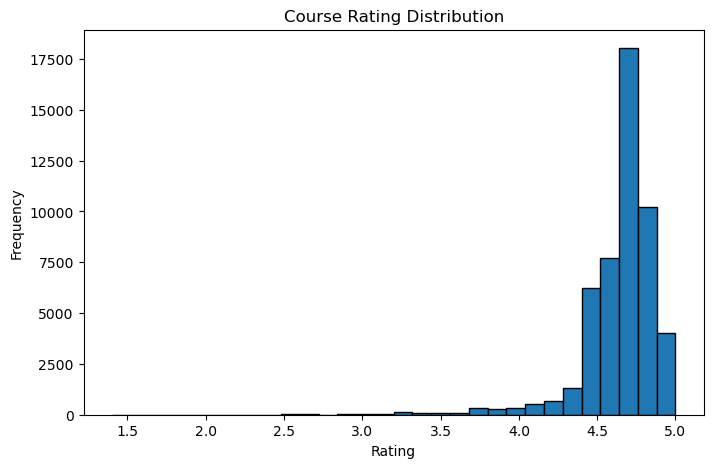

In [54]:
plt.figure(figsize=(8,5))
plt.hist(df['course_rating'], bins=30, edgecolor='k')
plt.title('Course Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

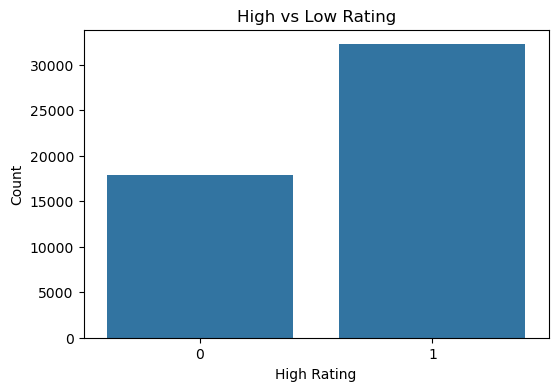

In [56]:
plt.figure(figsize=(6,4))
sns.countplot(x='high_rating', data=df)
plt.title('High vs Low Rating')
plt.xlabel('High Rating')
plt.ylabel('Count')
plt.show()

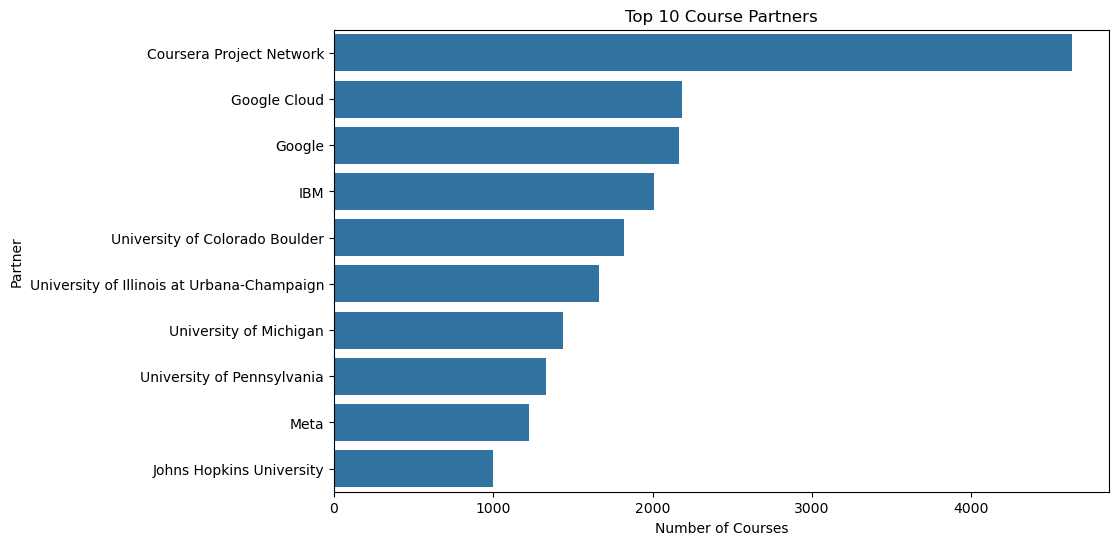

In [58]:
plt.figure(figsize=(10,6))
top_partners = df['course_partner'].value_counts().nlargest(10)
sns.barplot(y=top_partners.index, x=top_partners.values)
plt.title('Top 10 Course Partners')
plt.xlabel('Number of Courses')
plt.ylabel('Partner')
plt.show()

In [60]:
df.columns

Index(['user_input', 'course_title', 'course_partner', 'course_review',
       'skill_gain', 'course_rating', 'course_detail', 'course_title_clean',
       'skills_clean', 'course_review_clean', 'course_detail_clean',
       'skill_gain_list', 'num_skills', 'title_word_count', 'high_rating'],
      dtype='object')

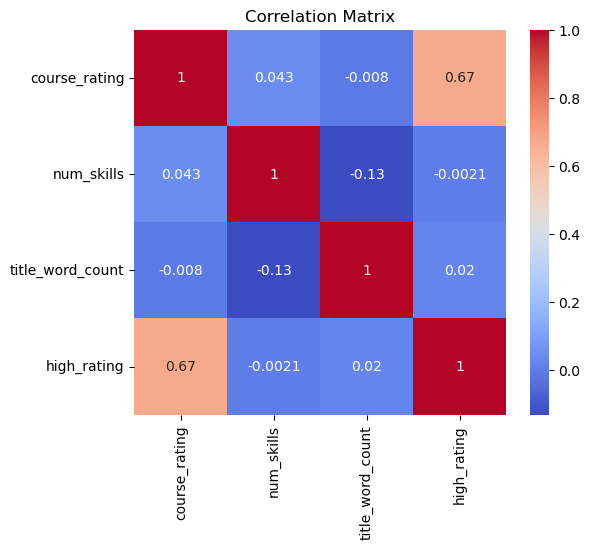

In [62]:
# Correlation among numeric features
plt.figure(figsize=(6,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

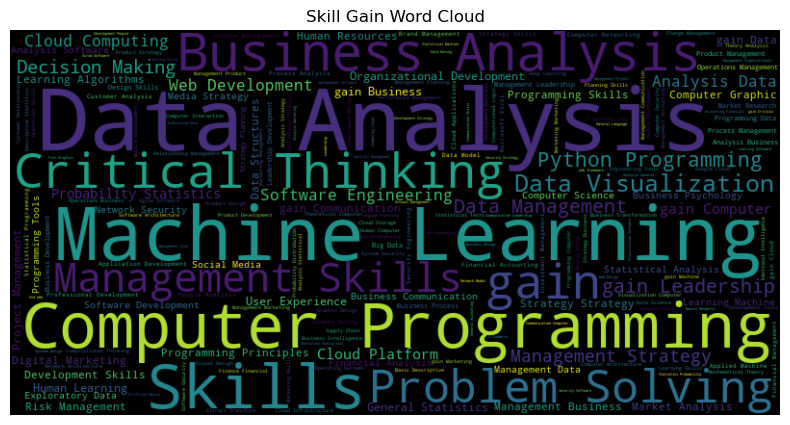

In [64]:
# Wordcloud for skills
all_skills = [skill for sub in df['skill_gain_list'] for skill in sub]
skill_text = ' '.join(all_skills)
wordcloud = WordCloud(width=800, height=400).generate(skill_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Skill Gain Word Cloud')
plt.show()

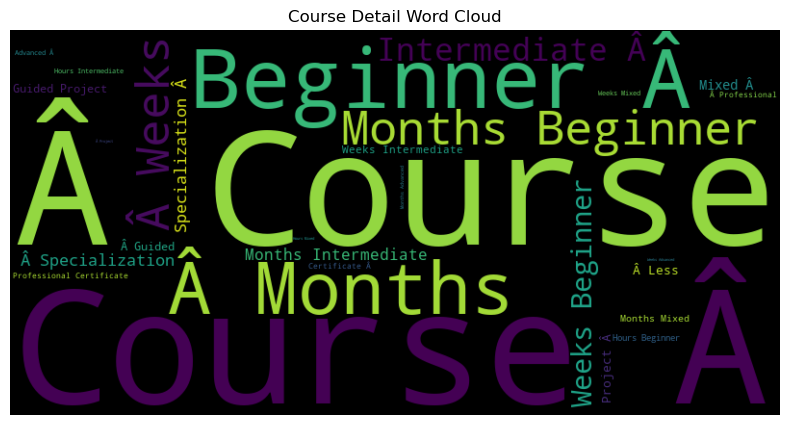

In [65]:
# Wordcloud for course_detail
detail_text = ' '.join(df['course_detail'])
wordcloud2 = WordCloud(width=800, height=400).generate(detail_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.title('Course Detail Word Cloud')
plt.show()

### 4. Dimensionality Reduction & Clustering
- Use TF-IDF + SVD + KMeans to cluster courses based on review & detail.

In [69]:
df

,user_input,course_title,course_partner,course_review,skill_gain,course_rating,course_detail,course_title_clean,skills_clean,course_review_clean,course_detail_clean,skill_gain_list,num_skills,title_word_count,high_rating
0,web_developement,Meta Front-End Developer,Meta,(18K reviews),"Skills you'll gain: HTML and CSS, Javascript, ...",4.7,Beginner Â· Professional Certificate Â· 3 - 6 ...,meta front end developer,"[skills you ll gain html and css, javascript,...",18k reviews,beginner professional certificate 3 6 months,"[Skills you'll gain: HTML and CSS, Javascript,...",23,4,1
1,web_developement,"HTML, CSS, and Javascript for Web Developers",Johns Hopkins University,(16K reviews),"Skills you'll gain: Front-End Web Development,...",4.7,Mixed Â· Course Â· 1 - 3 Months,"html, css, and javascript for web developers","[skills you ll gain front end web development,...",16k reviews,mixed course 1 3 months,[Skills you'll gain: Front-End Web Development...,4,7,1
2,web_developement,Web Design for Everybody: Basics of Web Develo...,University of Michigan,(34K reviews),"Skills you'll gain: Front-End Web Development,...",4.7,Beginner Â· Specialization Â· 3 - 6 Months,web design for everybody basics of web develop...,"[skills you ll gain front end web development,...",34k reviews,beginner specialization 3 6 months,[Skills you'll gain: Front-End Web Development...,19,9,1
3,web_developement,"Python for Data Science, AI & Development",IBM,(36K reviews),"Skills you'll gain: Python Programming, Comput...",4.6,Beginner Â· Course Â· 1 - 3 Months,"python for data science, ai development","[skills you ll gain python programming, compu...",36k reviews,beginner course 1 3 months,"[Skills you'll gain: Python Programming, Compu...",3,6,0
4,web_developement,Introduction to Web Development,"University of California, Davis",(3.6K reviews),"Skills you'll gain: Computer Programming, Fron...",4.7,Beginner Â· Course Â· 1 - 3 Months,introduction to web development,"[skills you ll gain computer programming, fro...",3 6k reviews,beginner course 1 3 months,"[Skills you'll gain: Computer Programming, Fro...",10,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50162,science,"Capstone: Retrieving, Processing, and Visualiz...",University of Michigan,(14K reviews),"Skills you'll gain: Computer Programming, Data...",4.7,Beginner Â· Course Â· 1 - 3 Months,"capstone retrieving, processing, and visualizi...","[skills you ll gain computer programming, dat...",14k reviews,beginner course 1 3 months,"[Skills you'll gain: Computer Programming, Dat...",4,8,1
50163,science,Positive Psychology: Applications and Interven...,University of Pennsylvania,(2.1K reviews),Skills you'll gain: Leadership and Management,4.8,Beginner Â· Course Â· 1 - 4 Weeks,positive psychology applications and intervent...,[],2 1k reviews,beginner course 1 4 weeks,[],1,5,1
50164,science,International Security Management,Erasmus University Rotterdam,(1.1K reviews),"Skills you'll gain: Leadership and Management,...",4.7,Beginner Â· Course Â· 1 - 3 Months,international security management,"[skills you ll gain leadership and management,...",1 1k reviews,beginner course 1 3 months,[Skills you'll gain: Leadership and Management...,2,3,1
50165,science,Primeros pasos en el proceso de diseÃ±o de UX:...,Google,(756 reviews),"Skills you'll gain: Communication, Design and ...",4.9,Beginner Â· Course Â· 1 - 3 Months,primeros pasos en el proceso de dise o de ux e...,"[skills you ll gain communication, design and...",756 reviews,beginner course 1 3 months,"[Skills you'll gain: Communication, Design and...",7,14,1


In [71]:
title_tfidf = TfidfVectorizer(max_features=400)
title_feat = title_tfidf.fit_transform(df['course_title_clean'])

review_tfidf = TfidfVectorizer(max_features=500)
review_feat = review_tfidf.fit_transform(df['course_review_clean'])

detail_tfidf = TfidfVectorizer(max_features=500)
detail_feat = detail_tfidf.fit_transform(df['course_detail_clean'])

In [73]:
# Reduce each by SVD
def reduce_svd(matrix, n=20):
    svd = TruncatedSVD(n_components=n, random_state=42)
    return svd.fit_transform(matrix)

In [75]:
title_red = reduce_svd(title_feat)
review_red = reduce_svd(review_feat)
detail_red = reduce_svd(detail_feat)

In [77]:
# Combine with numeric
X_cluster = np.hstack([title_red, review_red, detail_red, df[['num_skills']].values])

In [79]:
# PCA 2D for viz
X2d = PCA(n_components=2, random_state=42).fit_transform(X_cluster)
labels = KMeans(n_clusters=5, random_state=42).fit_predict(X2d)
df['cluster'] = labels

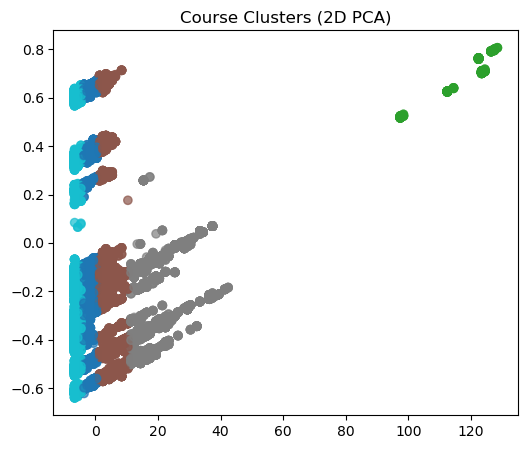

In [81]:
# Plot
plt.figure(figsize=(6,5))
plt.scatter(X2d[:,0], X2d[:,1], c=labels, cmap='tab10', alpha=0.7)
plt.title('Course Clusters (2D PCA)')
plt.show()


### 5. Modeling Pipelines
- Build unified pipelines for classification and regression.

In [84]:
# Preprocessing pipelines
text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=500))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


In [86]:
preprocessor = ColumnTransformer([
    ('title', text_pipe, 'course_title_clean'),
    ('review', text_pipe, 'course_review_clean'),
    ('detail', text_pipe, 'course_detail_clean'),
    ('num', num_pipe, ['num_skills',
                    'title_word_count']),
    ('cat', cat_pipe, ['course_partner'])
], sparse_threshold=0)

In [88]:
df.columns

Index(['user_input', 'course_title', 'course_partner', 'course_review',
       'skill_gain', 'course_rating', 'course_detail', 'course_title_clean',
       'skills_clean', 'course_review_clean', 'course_detail_clean',
       'skill_gain_list', 'num_skills', 'title_word_count', 'high_rating',
       'cluster'],
      dtype='object')

In [ ]:
# Classification: High Rating
clf = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

param_clf = {
    'model__n_estimators': [100,200],
    'model__max_depth': [None, 10]
}

Xc = df.drop(columns=['high_rating','course_rating','skill_gain_list','cluster'])
yc = df['high_rating']
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc,
                                                        test_size=0.2,
                                                        stratify=yc,
                                                        random_state=42)

grid_clf = GridSearchCV(clf, param_clf, cv=3, scoring='accuracy', n_jobs=-1)
grid_clf.fit(Xc_train, yc_train)
print("Best clf params:", grid_clf.best_params_)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

Best clf params: {'model__max_depth': None, 'model__n_estimators': 100}


### 6.  Model Evaluation

In [ ]:
# Classification eval
y_pred = grid_clf.predict(Xc_test)
print(classification_report(yc_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3582
           1       0.98      0.99      0.99      6452

    accuracy                           0.99     10034
   macro avg       0.99      0.98      0.98     10034
weighted avg       0.99      0.99      0.99     10034



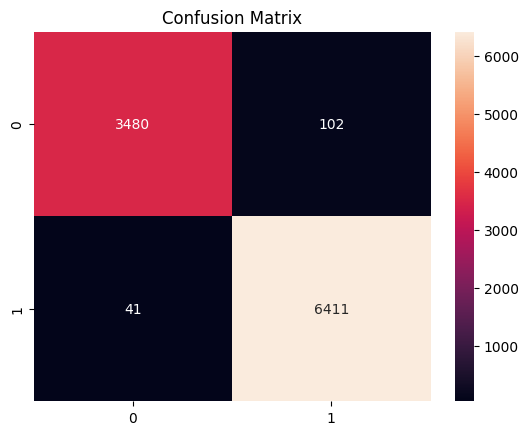

In [ ]:
cm = confusion_matrix(yc_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

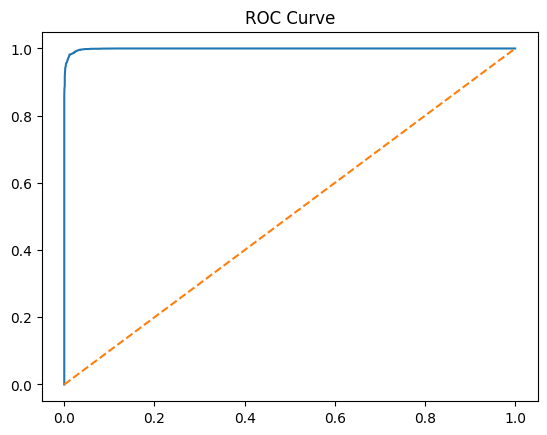

In [ ]:
probs = grid_clf.predict_proba(Xc_test)[:,1]
fpr, tpr, _ = roc_curve(yc_test, probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
plt.plot([0,1],[0,1],'--')
plt.title('ROC Curve')
plt.show()